<a href="https://colab.research.google.com/github/francotestori/dmctuba_01/blob/main/TP_1_Introducci%C3%B3n_al_an%C3%A1lisis_autom%C3%A1tico_de_sonido_y_de_m%C3%BAsica_con_datos_de_Spotify_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install spotipy
!pip -q install -U librosa seaborn

     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 


In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

sns.set_context('poster')

# Consigna 1:

Utilizando la API de Spotify se descargó la información de 4092 pistas de audio. Cada registro tiene variables de features de alto (*audio_features*), bajo nivel (*audio_analysis*) y metadata de los tracks. La idea es limpiar los campos a utilizar y hacer un primer análisis de los datos.

Para facilitar los primeros pasos utilizar una pequeña porción aleatoria de los datos e ir aumentando progresivamente. Observación: los datos de *audio_analysis* pesan 1.3 GB

# Dataset *tracks* 

-   De los datos de *tracks*, separar las etiquetas que se podrán utilizar para la validación externa (Artista, Álbum, Año, Género), de los campos que no se utilizarán.

# Dataset *audio_features*

El dataset *audio_features* contiene atributos globales de alto nivel para cada pista de audio.

-   Con los datos de *audio_features*, generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

# Dataset *audio_analysis*

El dataset *audio_analysis* contiene las variables continuas de bajo nivel, estimadas en ventanas temporales, como *timbre* o *pitches*. Como primer paso, deberán:

-   Resumir estas variables en valores por canción. Por ejemplo, tomar el promedio o el desvío estándar del timbre entre todas las ventanas, obteniendo 12 valores de timbre promedio y 12 valores de desvío estándar del timbre por canción.

-   Contruir un *data frame* con estos valores.

-   Generar un gráfico tipo *scatter matrix*.

-   Identificar variables más o menos informativas *a priori* y variables que requieran, además de la estandarización, alguna corrección para asimilar la distribución a una normal.

-   Estandarizar y volver a generar un gráfico tipo *scatter matrix*.

-   Identificar, si es que hay, valores extremos que sea necesario descartar.

## Bajamos los datos 



In [3]:
!wget https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1 -O audio_features.pickle
!wget https://www.dropbox.com/s/8d0y9bms80ly8ui/tracks.pickle?dl=1 -O tracks.pickle
!wget https://www.dropbox.com/s/1cmb8e8zvv6hsfs/audio_analysis.pickle?dl=1 -O audio_analysis.pickle

--2020-10-09 19:00:44--  https://www.dropbox.com/s/ms6260jqmsmz5qu/audio_features.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ms6260jqmsmz5qu/audio_features.pickle [following]
--2020-10-09 19:00:44--  https://www.dropbox.com/s/dl/ms6260jqmsmz5qu/audio_features.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0a27f6d9401af108f4dca09aa8.dl.dropboxusercontent.com/cd/0/get/BA8wUkS4rjq_kpTKiDZ2P_4Fq_4oLWHOXnvT5sqm8lTJKOFnC8dgDHLXHWN7rHj1NrP8TyOixX645rM2tuMwAj6XZHSEtR_PrvgLKuzPMdw0by8mAbK57jfPvm7B63XNB5k/file?dl=1# [following]
--2020-10-09 19:00:44--  https://uc0a27f6d9401af108f4dca09aa8.dl.dropboxusercontent.com/cd/0/get/BA8wUkS4rjq_kpTKiDZ2P_4Fq_4oLWHOXnvT5sqm8lTJKOFnC8dgDHLXHWN7rHj1NrP8TyOixX645rM2tuMwA

In [4]:
df_tracks = pd.read_pickle('tracks.pickle')
df_af = pd.read_pickle('audio_features.pickle')
df_aa = pd.read_pickle('audio_analysis.pickle')

In [5]:
# métodos equivalentes para extraer subgrupos por id
# for id in df_aa['id'].unique():
#  g = df_aa[df_aa['id']==id]
#  pass

# for id, g in df_aa.groupby('id'):
#  pass

KeyboardInterrupt: ignored

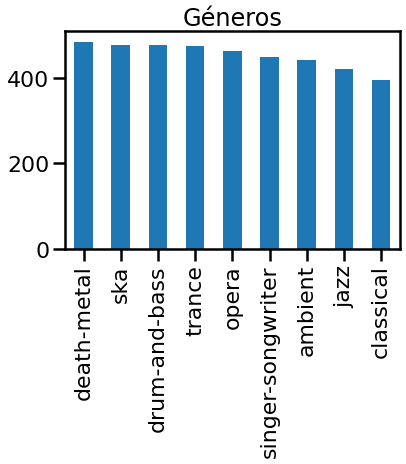

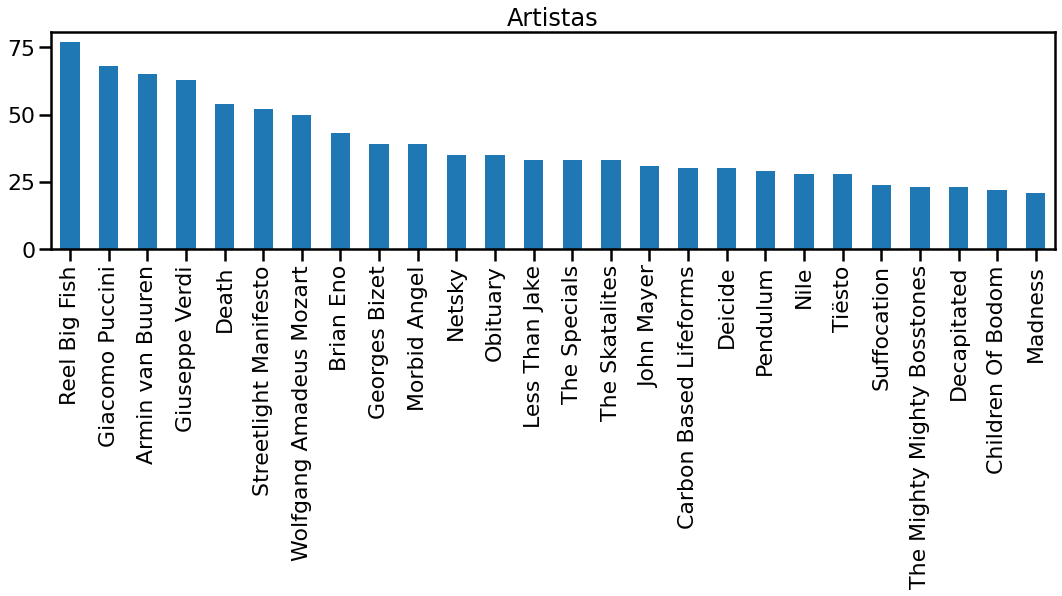

In [6]:
df_tracks['genre'].value_counts().plot.bar(figsize=(6,4));
plt.title('Géneros')
plt.show()
df_tracks['artists'].value_counts()[:26].plot.bar(figsize=(18,4));
plt.title('Artistas');

### Extraer información de un campo con diccionarios dentro de un DataFrame

Veamos el primer item del campo 'album' que tiene diccionarios dentro

In [7]:
print(df_tracks.iloc[0]['album'])

{'album_type': 'ALBUM', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6dUZplQfg5blo0h9HiJ94d'}, 'href': 'https://api.spotify.com/v1/artists/6dUZplQfg5blo0h9HiJ94d', 'id': '6dUZplQfg5blo0h9HiJ94d', 'name': 'Tommy Flanagan', 'type': 'artist', 'uri': 'spotify:artist:6dUZplQfg5blo0h9HiJ94d'}], 'available_markets': ['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE', 'BG', 'BH', 'BO', 'BR', 'BY', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'KZ', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MD', 'ME', 'MK', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SG', 'SI', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'UA', 'US', 'UY', 'VN', 'XK', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/0O6FZJtO0RcQEDu3t55vF4'}, 'href': 'https://a

Si identificamos que key tomar del diccionario, podemos utilizar la función map para indicar que para cada diccionario de cada entrada tome el key deseado, en este caso 'release_date'


In [8]:
df_tracks['release_date'] = df_tracks['album'].map(lambda x: x['release_date'])
df_tracks['release_date']

id
4d3XHYFFuYYzxWr2cJ6yQl          1991
3X3p3u03P8eFL8WTH0oaaU          1958
4KlXeaheot0OI9PoOWspvZ    2014-01-01
3j76McoUI18gDoqxYE14Bu    2014-11-10
4zxd4tiXPlWMqoJltbVTbE    1959-08-17
                             ...    
5vSsQH8wH68PDKJbNfxzpc    2011-03-21
7xYKAlU77jAAnAixQ5IgSn    2012-07-20
4hXEgyy5nNgdiBvJcJ9o8u    2009-02-23
4HpSbJgNpoOphIeCK3z9sk    2008-08-25
30KzbX1viF0aTL1NS5coDY    2010-07-19
Name: release_date, Length: 4092, dtype: object

Como tenemos formatos de fechas mixtos tenemos que extraer el año según cada caso

In [9]:
def date_formator(date):
    if '-' in date:
        year = pd.to_datetime(date, format = '%Y-%m-%d').year
        return int(year)
    elif int(date)>0:
        year = pd.to_datetime(date, format = '%Y').year
        return int(year)
    return None
       
df_tracks['release_date'] = df_tracks['release_date'].apply(date_formator)
df_tracks['release_date']

id
4d3XHYFFuYYzxWr2cJ6yQl    1991.0
3X3p3u03P8eFL8WTH0oaaU    1958.0
4KlXeaheot0OI9PoOWspvZ    2014.0
3j76McoUI18gDoqxYE14Bu    2014.0
4zxd4tiXPlWMqoJltbVTbE    1959.0
                           ...  
5vSsQH8wH68PDKJbNfxzpc    2011.0
7xYKAlU77jAAnAixQ5IgSn    2012.0
4hXEgyy5nNgdiBvJcJ9o8u    2009.0
4HpSbJgNpoOphIeCK3z9sk    2008.0
30KzbX1viF0aTL1NS5coDY    2010.0
Name: release_date, Length: 4092, dtype: float64

# Extracción de etiquetas para validación externa de dataset tracks

In [10]:
df_tracks_modificado = pd.DataFrame() #Genero nuevo df_tracks
df_tracks_modificado['album_id'] = df_tracks['album'].map(lambda x: x['id']) #Obtengo ids de album

In [11]:
df_tracks_modificado[["artista","genero"]] =  df_tracks.loc[:,["artists","genre"]] #Agrego artistas y género

In [12]:
df_tracks_modificado['Año'] = df_tracks['release_date'] #Agrego año de lanzamiento

In [13]:
df_tracks_modificado

,album_id,artista,genero,Año
4d3XHYFFuYYzxWr2cJ6yQl,0O6FZJtO0RcQEDu3t55vF4,Tommy Flanagan,jazz,1991.0
3X3p3u03P8eFL8WTH0oaaU,35GC6fz2v6ZoXcVlKf6BA6,Art Farmer,jazz,1958.0
4KlXeaheot0OI9PoOWspvZ,72mQPtb0Xzv71uhsznTUK4,Christian Scott aTunde Adjuah,jazz,2014.0
3j76McoUI18gDoqxYE14Bu,5hUjimESHfgftKXaM5nk7E,Skalpel,jazz,2014.0
4zxd4tiXPlWMqoJltbVTbE,4sb0eMpDn3upAFfyi4q2rw,Miles Davis,jazz,1959.0
...,...,...,...,...
5vSsQH8wH68PDKJbNfxzpc,0sVSc9YNjt5H8KBZh8YWbR,Arctic Moon,trance,2011.0
7xYKAlU77jAAnAixQ5IgSn,6T1bGQht0grBiVzML8cFe3,Solarstone,trance,2012.0
4hXEgyy5nNgdiBvJcJ9o8u,2nAu3o78jApge9iSi9ZuGH,Richard Durand,trance,2009.0
4HpSbJgNpoOphIeCK3z9sk,7awvvLmFmxgdL3i4Yn4iJt,Chicane,trance,2008.0


# Dataset Audio Features

## Scatter Matrix

In [29]:
df_af

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
id,,,,,,,,,,,,,,,,,
6avAsaa2IsXHT2mtQ6cGVe,0.6040,0.9630,7,-4.622,1,0.1250,0.002840,0.846000,0.0769,0.2750,172.020,audio_features,spotify:track:6avAsaa2IsXHT2mtQ6cGVe,https://api.spotify.com/v1/tracks/6avAsaa2IsXH...,https://api.spotify.com/v1/audio-analysis/6avA...,388663,4
6fvu2d6gHAdiNCMco4lTxK,0.0677,0.0581,2,-25.662,0,0.0402,0.994000,0.567000,0.1170,0.0372,73.509,audio_features,spotify:track:6fvu2d6gHAdiNCMco4lTxK,https://api.spotify.com/v1/tracks/6fvu2d6gHAdi...,https://api.spotify.com/v1/audio-analysis/6fvu...,283653,3
5GmrXcVIMgLaaqKVxhi5kp,0.2590,0.2420,2,-15.790,1,0.0401,0.530000,0.000003,0.0714,0.3050,178.132,audio_features,spotify:track:5GmrXcVIMgLaaqKVxhi5kp,https://api.spotify.com/v1/tracks/5GmrXcVIMgLa...,https://api.spotify.com/v1/audio-analysis/5Gmr...,213640,3
1DMIHggF47tqsO468VUDmd,0.2420,0.4450,4,-7.421,0,0.0318,0.494000,0.000224,0.1860,0.0867,86.289,audio_features,spotify:track:1DMIHggF47tqsO468VUDmd,https://api.spotify.com/v1/tracks/1DMIHggF47tq...,https://api.spotify.com/v1/audio-analysis/1DMI...,247933,4
78Ovt1QkZbU1QBMKWpcXPy,0.7010,0.8060,9,-5.508,1,0.1480,0.183000,0.003750,0.1230,0.9750,147.150,audio_features,spotify:track:78Ovt1QkZbU1QBMKWpcXPy,https://api.spotify.com/v1/tracks/78Ovt1QkZbU1...,https://api.spotify.com/v1/audio-analysis/78Ov...,168112,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4fZhnxi2b29JvSBzAZtmqT,0.5530,0.5850,8,-8.771,1,0.0426,0.055200,0.908000,0.1140,0.1760,174.002,audio_features,spotify:track:4fZhnxi2b29JvSBzAZtmqT,https://api.spotify.com/v1/tracks/4fZhnxi2b29J...,https://api.spotify.com/v1/audio-analysis/4fZh...,359732,4
1POLDZ0XBX9ycnCkxVKCoZ,0.4730,0.4210,7,-12.409,1,0.0451,0.684000,0.000483,0.0529,0.4970,93.280,audio_features,spotify:track:1POLDZ0XBX9ycnCkxVKCoZ,https://api.spotify.com/v1/tracks/1POLDZ0XBX9y...,https://api.spotify.com/v1/audio-analysis/1POL...,215533,4
0bXpmJyHHYPk6QBFj25bYF,0.6170,0.7780,9,-8.871,0,0.0270,0.459000,0.925000,0.1280,0.1520,100.363,audio_features,spotify:track:0bXpmJyHHYPk6QBFj25bYF,https://api.spotify.com/v1/tracks/0bXpmJyHHYPk...,https://api.spotify.com/v1/audio-analysis/0bXp...,127920,4


In [30]:
df_af.columns
features = pd.Series(['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'])
df_af[features]
df_af_modificado = df_af[features]

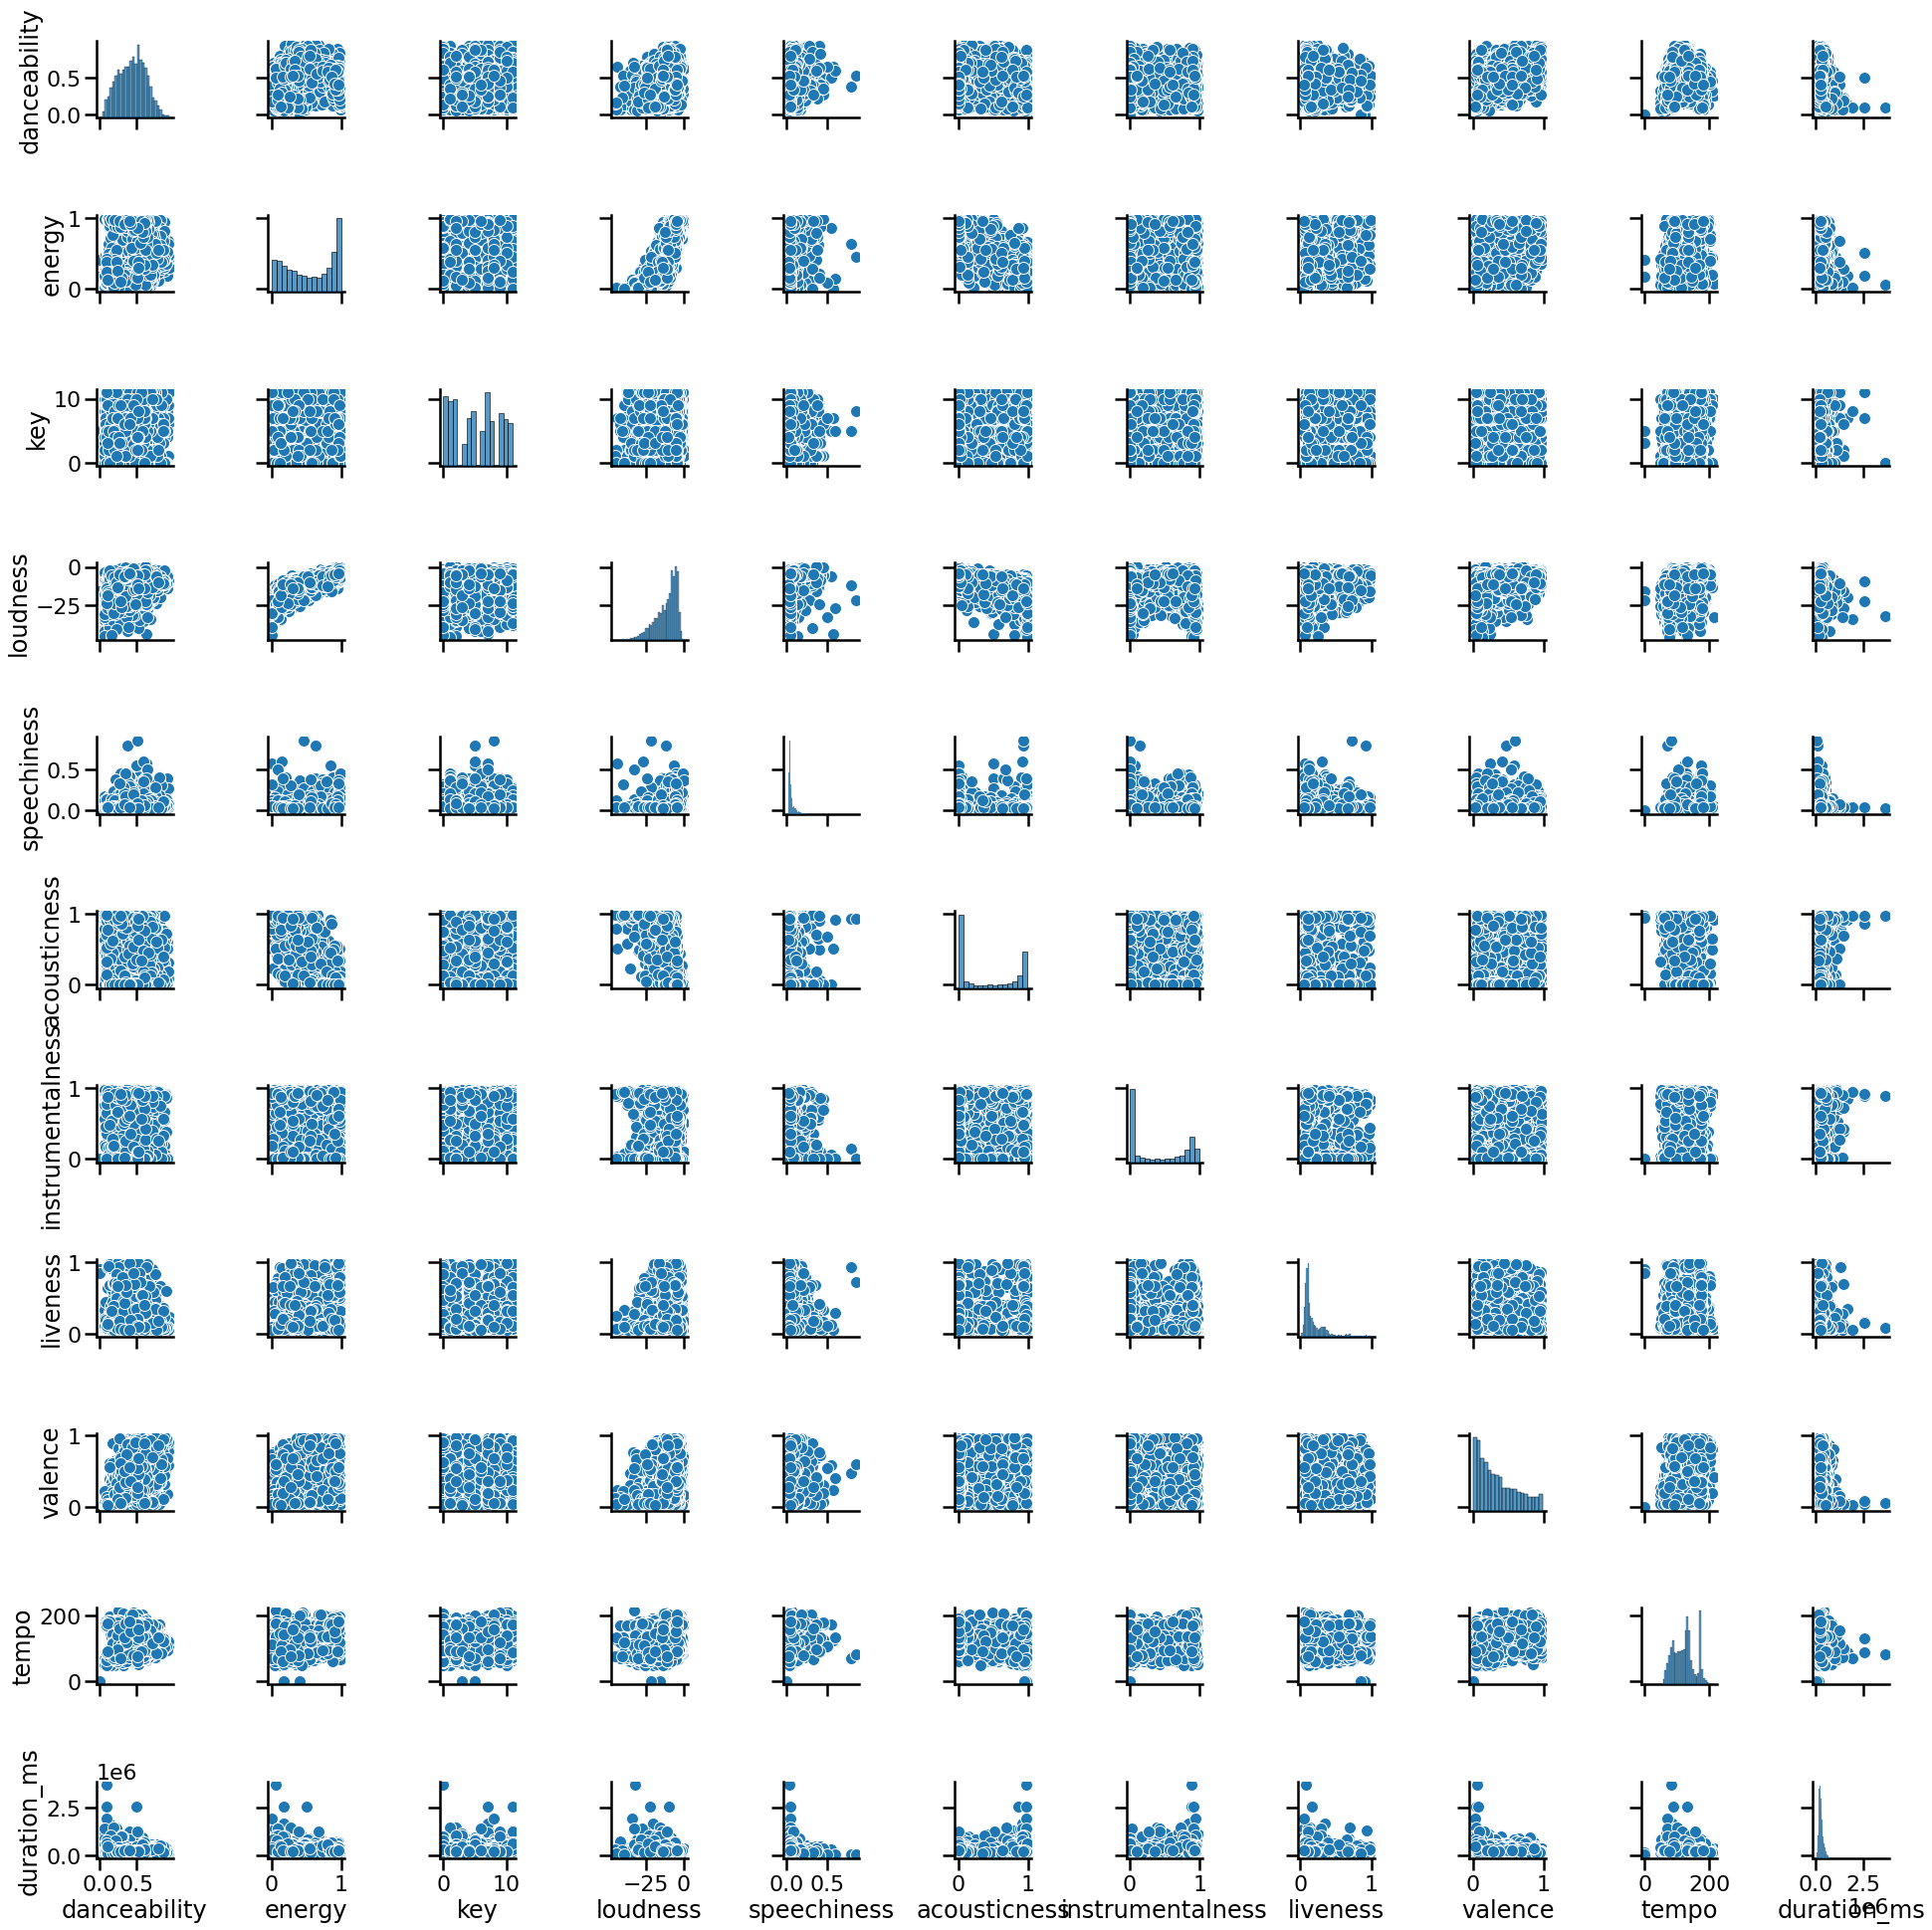

In [31]:
sns.pairplot(pd.concat([features,df_af_modificado],axis=1))

## Variables Informativas

Las variables más informativas son ... 

## Variables que requieren transformación

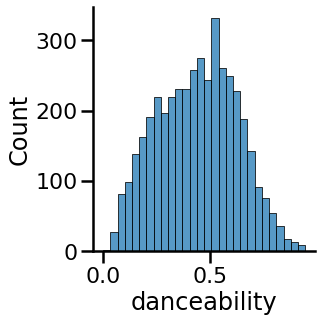

In [32]:
sns.displot(df_af_modificado, x="danceability")

In [43]:
from sklearn.preprocessing import quantile_transform
df_af_modificado_2 = pd.DataFrame(quantile_transform(df_af_modificado, output_distribution = 'normal', random_state=0, copy=True))
df_af_modificado_2.columns =pd.Series(['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'])
df_af_modificado_2

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.810910,1.258508,0.356159,1.035555,1.269664,-0.622040,0.728240,-1.124870,0.007527,1.130744,0.947979
1,-2.474160,-1.463311,-0.616541,-1.588126,-0.461215,2.289988,0.257224,-0.058999,-1.639539,-1.550858,0.234656
2,-0.851675,-0.628724,-0.616541,-0.648800,-0.472407,0.205941,-1.243405,-1.275302,0.096753,1.922028,-0.455640
3,-0.955471,-0.202527,-0.260089,0.342160,-1.381364,0.180312,-0.798713,0.475214,-0.787152,-0.946818,-0.100977
4,1.421556,0.357496,0.888309,0.761322,1.458748,-0.030114,-0.502629,0.030114,2.800211,0.800799,-1.131165
...,...,...,...,...,...,...,...,...,...,...,...
4265,0.536531,0.003764,0.624145,0.096740,-0.266584,-0.198719,1.247505,-0.132113,-0.341493,1.317212,0.790717
4266,0.112563,-0.242704,0.356159,-0.314027,-0.104318,0.315012,-0.728016,-1.864814,0.596935,-0.703275,-0.433176
4267,0.893908,0.299967,0.888309,0.083595,-2.325972,0.150125,1.501861,0.095492,-0.445919,-0.516951,-1.714446
4268,-0.205941,1.192071,-0.981540,0.753647,0.934427,-1.364874,0.170185,0.604370,0.254992,-0.309138,-0.206150


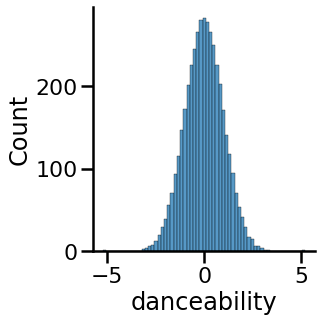

In [44]:
sns.displot(df_af_modificado_2, x="danceability")

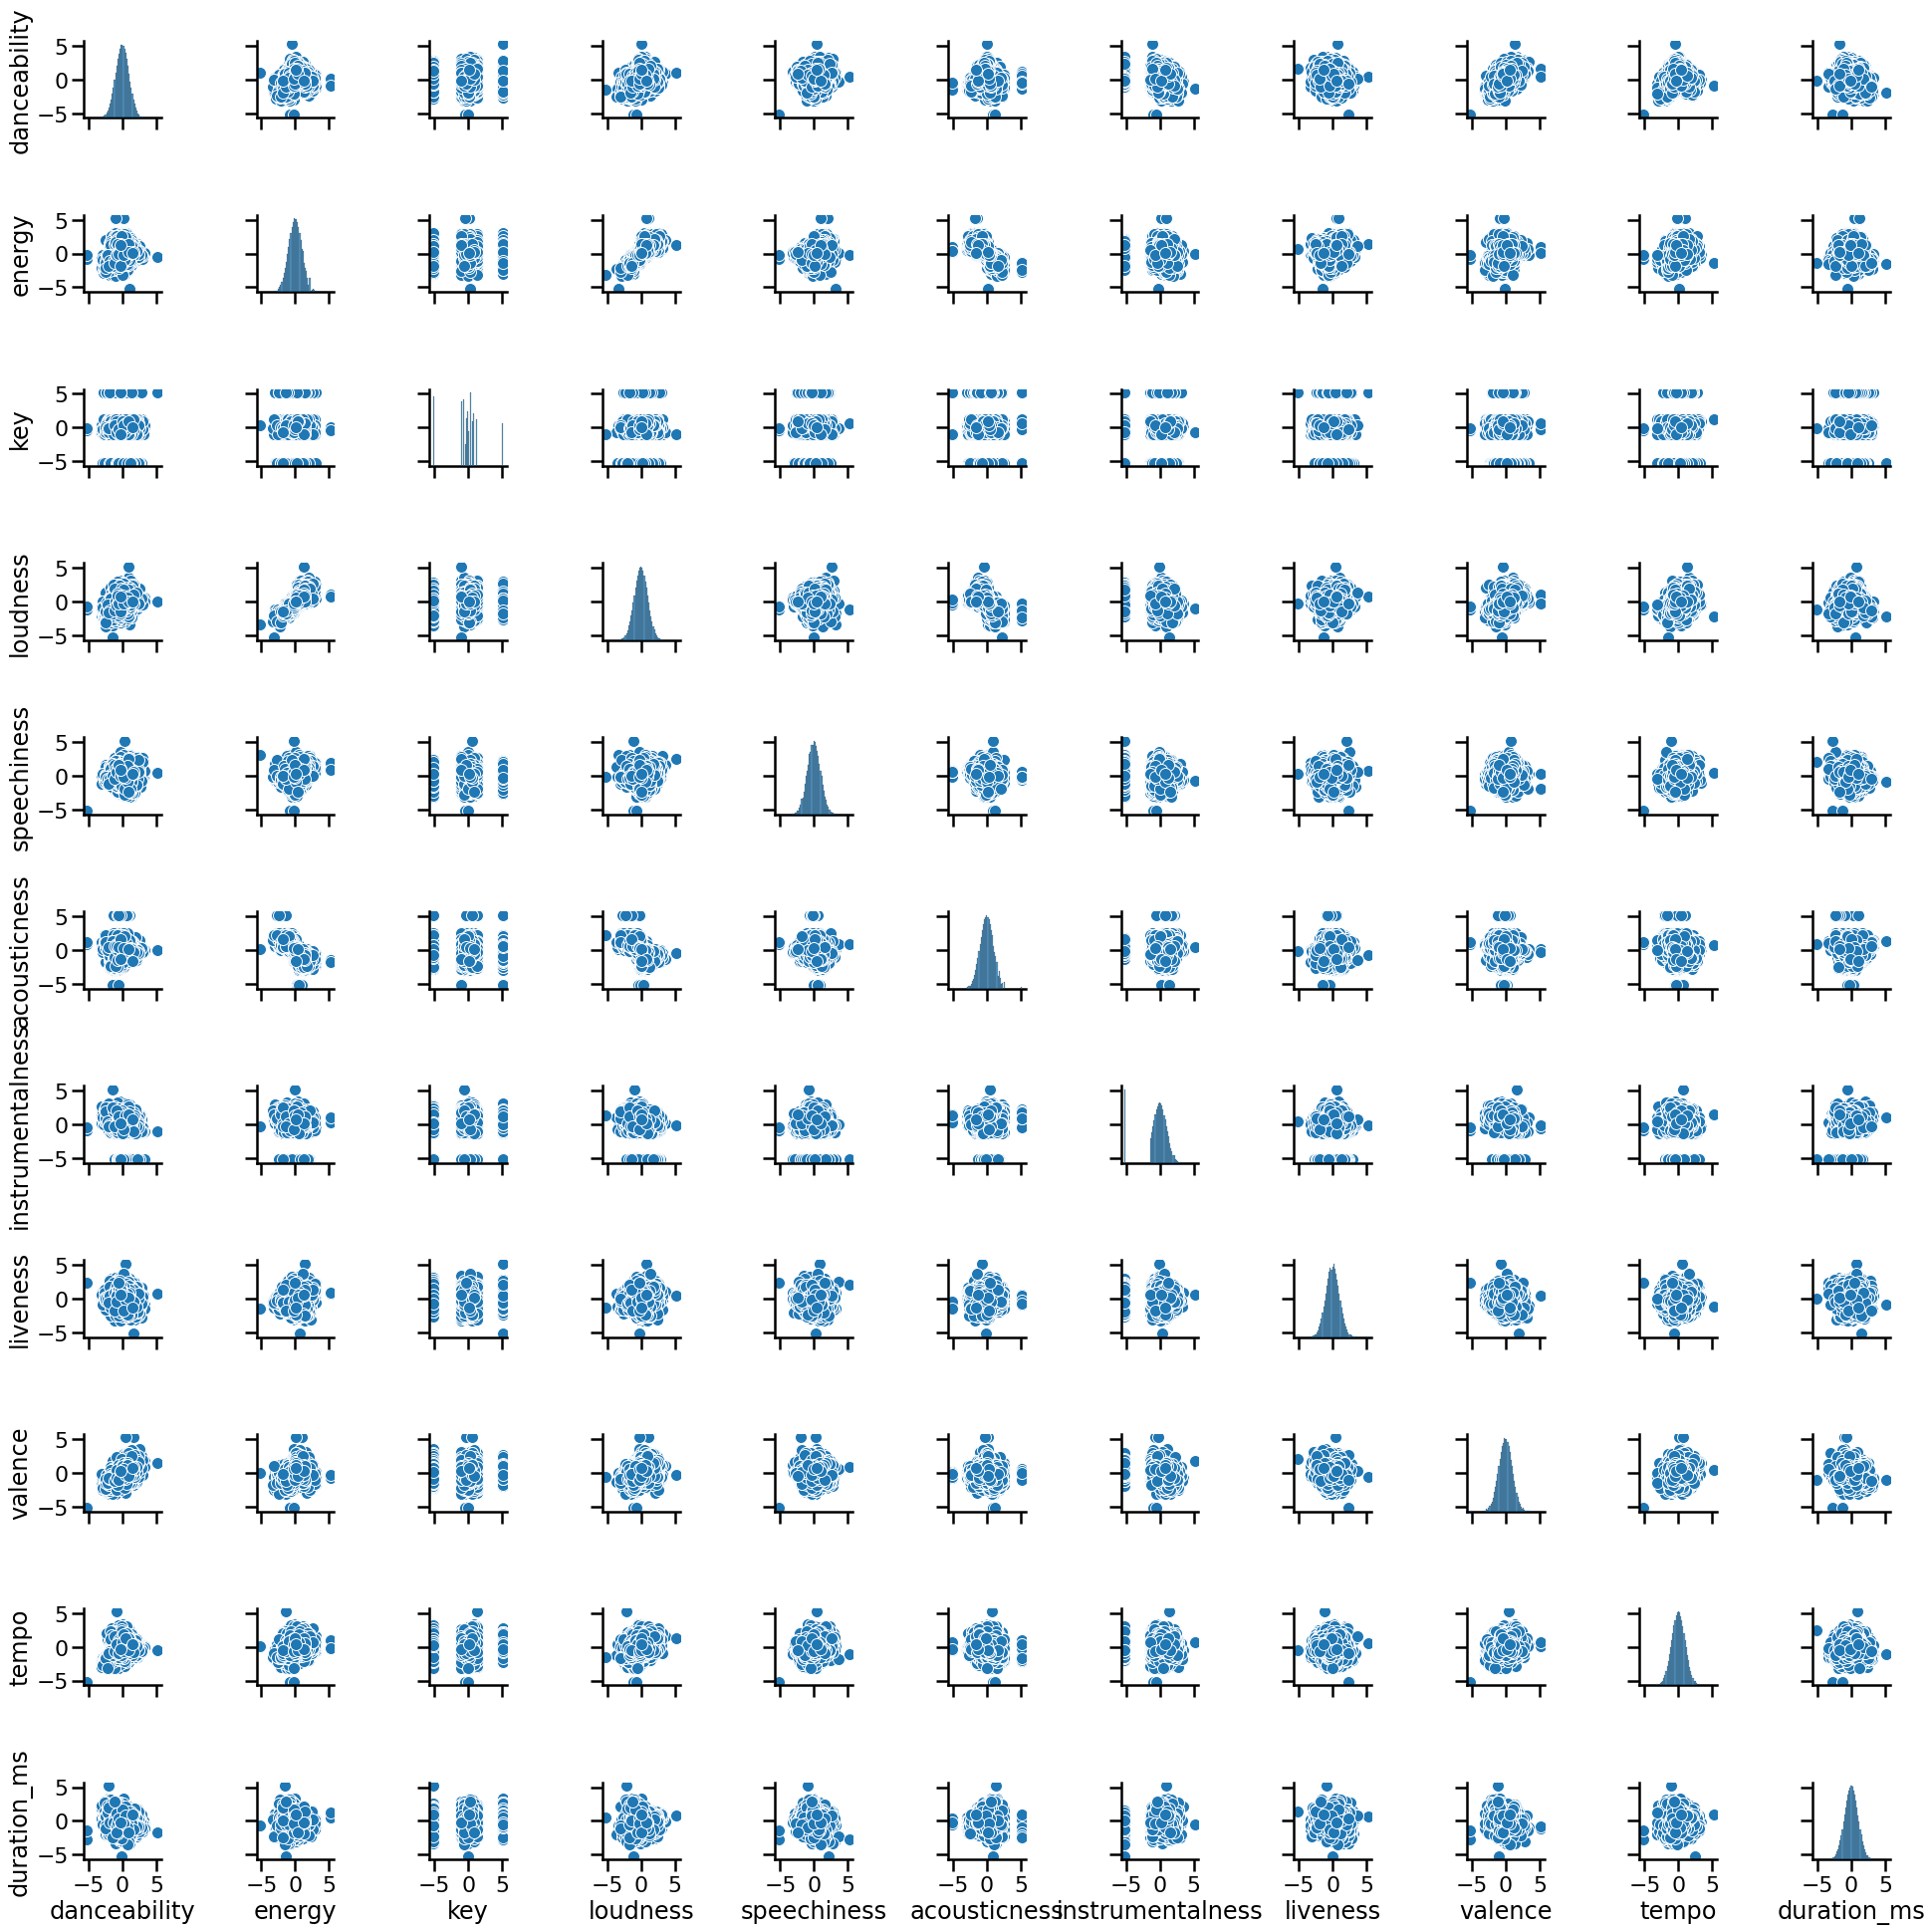

In [45]:
sns.pairplot(pd.concat([features,df_af_modificado_2],axis=1))

## Outliers

### Distancia de Mahalanobis

In [48]:
import scipy as sp
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

df_x = df_af_modificado_2[['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
df_x['mahala'] = mahalanobis(x=df_x, data=df_af_modificado_2[['danceability', 'energy', 'key', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']])
df_x.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,mahala
0,0.810910,1.258508,0.356159,1.035555,1.269664,-0.622040,0.728240,-1.124870,0.007527,1.130744,0.947979,7.349799
1,-2.474160,-1.463311,-0.616541,-1.588126,-0.461215,2.289988,0.257224,-0.058999,-1.639539,-1.550858,0.234656,11.097037
2,-0.851675,-0.628724,-0.616541,-0.648800,-0.472407,0.205941,-1.243405,-1.275302,0.096753,1.922028,-0.455640,10.982377
3,-0.955471,-0.202527,-0.260089,0.342160,-1.381364,0.180312,-0.798713,0.475214,-0.787152,-0.946818,-0.100977,5.789702
4,1.421556,0.357496,0.888309,0.761322,1.458748,-0.030114,-0.502629,0.030114,2.800211,0.800799,-1.131165,12.366969


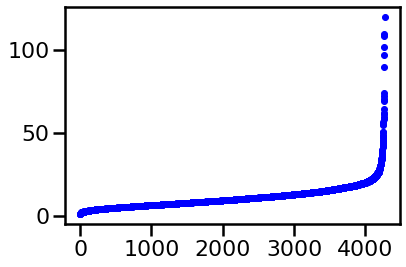

In [60]:
plt.plot(df_x['mahala'].sort_values().reset_index()['mahala'],'b.')

In [ ]:
df_x['mahala'].sort_values().reset_index()['mahala']

Acá se podría setear un valor de corte donde se dispara, por ejemplo desde cierta distancia de Mahalanobis que se corresponde con número de muestra 4000 aprox

# Dataset Audio Analysis

In [ ]:
df_aa

In [ ]:
df_aa_modificado = df_aa
s = df_aa.apply(lambda x: pd.Series(x['pitches']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'pitches'
df_aa_modificado.drop('pitches', axis=1).join(s)